# Report on the Economic Impact of Homicides

**By:** Nick Hand<br>
**Date:** 10/23/2019

This notebook details part of the analysis conducted by the Office of the City Controller presented in "Report on the Economic Impact of Homicides." The full report is available [here](https://controller.phila.gov/philadelphia-audits/economic-impact-of-homicides/).

The report updates a 2012 study by the Center for American Progress that examined the economic impact of reducing violent crime in eight cities, including Philadelphia. It identified property tax revenue from increased rising housing values as the largest source of potential savings for municipalities with the reduction of homicides. With that in mind, the Controller’s Office analyzed all homicides and more than 220,000 residential property sales that occurred between 2006 and 2018 in Philadelphia to quantify the effect of a single homicide on residential sale prices and to estimate the potential increase in the City’s property tax revenue associated with reducing homicides by 10 percent annually over five years.

### Findings 

The analysis found that homicides have a sizable effect on residential property values, indicating that a single homicide lowers sale prices by 2.3 percent in the immediate neighborhood (within 0.75 miles of the homicide). Additionally, the analysis showed that decreasing the number of homicides would have a positive impact on residential property values. Reducing homicides by 10 percent in a single year would translate into a \\$13 million increase in property tax revenue, and \\$114 million over five years with a 10 percent reduction in homicides annually.

## Setup

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

## Loading the data

In [1]:
import gun_violence.datasets as gv_data

### Residental sale data

The analysis uses data for residential property sales that occurred in Philadelphia from 2006 to 2018 as provided by the Office of Property Assessment. The dataset includes sale information, such as date and price, as well as characteristics of the property being sold, such as its location, square footage, and exterior condition. 

Only residential sales are included in our primary analysis, and outlier sales have been excluded using the interquartile range of the log of the sale price. Sale prices have been adjusted to account for inflationary
trends in housing values in the Philadelphia region during the period studied, using the [All-Transactions House Price Index for the Philadelphia MSA](https://fred.stlouisfed.org/series/ATNHPIUS37964Q).

In [37]:
# Load all the sales
sales = gv_data.ResidentialSales.get()

# Remove any sales without locations
sales = sales.loc[sales.geometry.notnull()]

In [38]:
sales.head()

,assessment_date,basements,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,...,unfinished,utility,view_type,year_built,zip_code,zoning,ln_sale_price,ln_sale_price_indexed,is_condo,time_offset
0,NaN,D,3469324.0,R30,ROW B/GAR 2 STY MASONRY,1.0,Single Family,180.0,N,NaN,...,NaN,NaN,C,1948.0,19111.0,RSA5,11.813030,11.815865,False,410140800.0
1,NaN,NaN,3462757.0,C36,DET W/D GAR 2 STY FRAME,1.0,Single Family,920.0,N,NaN,...,NaN,NaN,I,1925.0,19111.0,RSA3,11.695247,11.698082,False,410140800.0
2,NaN,D,3465839.0,H30,SEMI/DET 2 STY MASONRY,1.0,Single Family,730.0,N,NaN,...,NaN,NaN,I,1920.0,19111.0,RSA5,11.561716,11.564551,False,410140800.0
3,NaN,H,3465847.0,R31,ROW B/GAR 2 STY MAS+OTHER,1.0,Single Family,322.0,NaN,NaN,...,NaN,NaN,I,1955.0,19154.0,RSA4,12.117241,12.120076,False,410140800.0
4,NaN,F,3464022.0,R31,ROW B/GAR 2 STY MAS+OTHER,1.0,Single Family,550.0,NaN,NaN,...,NaN,NaN,C,1955.0,19151.0,RM1,11.827736,11.830571,False,410140800.0


In [39]:
print(f"Total number of sales: {len(sales):,}")

Total number of sales: 432,048


Plot the distribution of sales across Philadelphia:

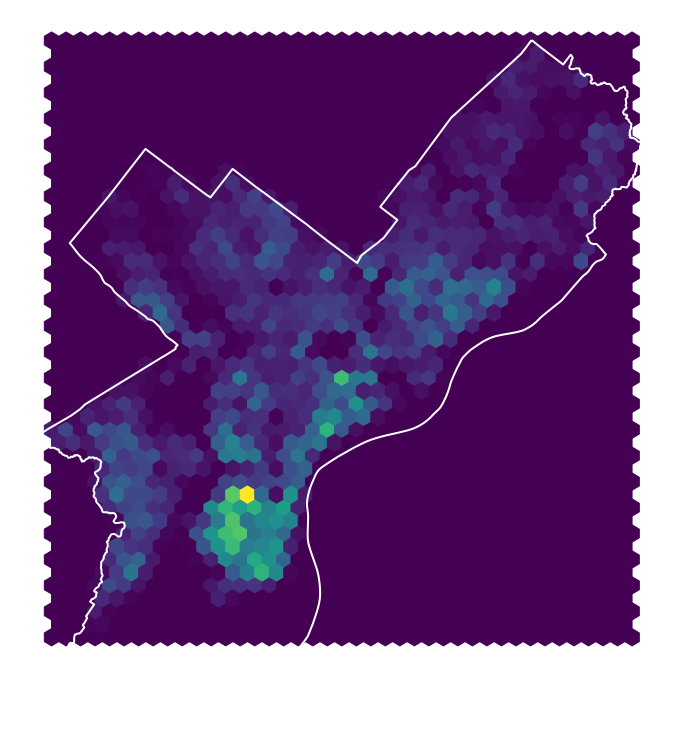

In [36]:
# Project to Web Mercator
sales_3857 = sales.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10,10), gridspec_kw=dict(left=0, right=1, bottom=0, top=1))
ax.hexbin(sales_3857.geometry.x, sales_3857.geometry.y, cmap='viridis', gridsize=40)

# Add the city limits
city_limits = gv_data.CityLimits.get().to_crs(epsg=3857)
city_limits.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=2)

# Format
PAD = 2000
xmin, ymin, xmax, ymax = city_limits.total_bounds
ax.set_xlim(xmin-PAD, xmax+PAD)
ax.set_ylim(ymin-PAD, ymax+PAD)
ax.set_axis_off()
ax.set_aspect("equal")

### Homicide data

The analysis also uses data from the Philadelphia Police Department for the 4,121 homicides that occurred in Philadelphia from 2006 to 2018. The dataset includes information on the location of each homicide, as well as information on the victim's race and gender and the weapon used. 

In [40]:
# Load all of the homicides
homicides = gv_data.PoliceHomicides.get()

# Remove homicides without a location
homicides = homicides.loc[homicides.geometry.notnull()]

In [5]:
homicides.head()

,age,dc_key,dispatch_date_time,geometry,hispanic,location_block,neighborhood,police_district,race,sex,time_offset,weapon,year,zip_code
0,26,201835109550,2018-12-30 21:00:00+00:00,POINT (2704073.09179473 268608.071022134),0,100 BLOCK WIDENER ST,Olney,35.0,Black,Male,410130000.0,firearm,2018,19120.0
1,40,201815115762,2018-12-29 23:00:00+00:00,POINT (2718743.221626258 265304.526845683),0,2100 BLOCK LARDNER ST,Mayfair,15.0,White,Male,410050800.0,knife,2018,19149.0
2,25,201815115971,2018-12-29 18:00:00+00:00,POINT (2714424.617601689 256751.803263876),0,2000 BLOCK WOMRATH STR,Frankford,15.0,Black,Male,410032800.0,firearm,2018,19124.0
3,28,201822103803,2018-12-28 01:00:00+00:00,POINT (2693178.283887419 249037.8621782725),0,2200 BLOCK N GRATZ ST,Stanton,22.0,Black,Male,409885200.0,firearm,2018,19132.0
4,22,201822103800,2018-12-28 01:00:00+00:00,POINT (2693178.283887419 249037.8621782725),0,2200 BLOCK N GRATZ ST,Stanton,22.0,Black,Male,409885200.0,firearm,2018,19132.0


Plot the distribution of homicides across the city:

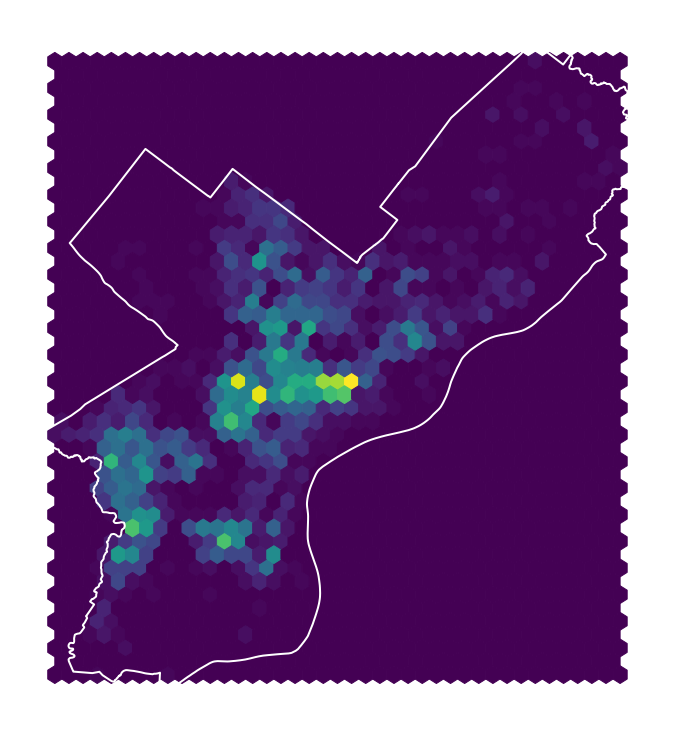

In [35]:
# Project to Web Mercator
homicides_3857 = homicides.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10,10), gridspec_kw=dict(left=0, right=1, bottom=0, top=1))
ax.hexbin(homicides_3857.geometry.x, homicides_3857.geometry.y, cmap='viridis', gridsize=40)

# Add the city limits
city_limits = gv_data.CityLimits.get().to_crs(epsg=3857)
city_limits.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=2)

# Format
PAD = 2000
xmin, ymin, xmax, ymax = city_limits.total_bounds
ax.set_xlim(xmin-PAD, xmax+PAD)
ax.set_ylim(ymin-PAD, ymax+PAD)
ax.set_axis_off()
ax.set_aspect("equal")

## Regression analysis

The analysis relies on a hedonic pricing model with a difference-in-differences (DID) technique to estimate any causal effect of homicides on local property values. The major concern in this type of analysis is bias from omitted variables, such as an unknown and unaccounted for disamenity that negatively influences housing prices near homicides. To overcome these concerns, we use a spatial DID technique of the form:

$$
\mathrm{log}(P_{ijt}) = \alpha_{jt} + \boldsymbol{\beta}\boldsymbol{}{X_i} 
    + \pi_0 D_{ijt}^\mathrm{0.75} + \pi_1 D_{ijt}^\mathrm{0.75} * Post_{it}
    + \epsilon_{ijt}.
$$

The log of the sale price of property $i$ is a function of a neighborhood $j$
by year $t$ fixed effect ($\alpha_{jt}$), individual property characteristics
($\boldsymbol{X_i}$), and a random error term ($\epsilon_{ijt}$). The indicator
variable $D_{ijt}^{\mathrm{0.75}}$ has a value of one when the sale occurred
within 0.75 miles of a homicide and a value of zero if it occurred between 0.75
and 1.5 miles of a homicide. The interaction variable $Post_{it}$ indicates
whether the sale occurred within the 60 days following a homicide. The key
parameter in this framework is $\pi_1$, which provides an estimate of the causal
effect of homicides on local sale prices for properties within 0.75 miles of a
homicide.

### Step 1: Add interaction flags

First, we will analyze the homicide and sales datasets to add the spatial indicator and interaction terms in the above equation.

Below, we add a column representing $D_{ijt}^{\mathrm{0.75}}$ and another column representing $D_{ijt}^{\mathrm{0.75}} * Post_{it}$.

Note: only sales that occur within 1.5 miles of any homicide are included in the final regression analysis.

In [42]:
from gun_violence.modeling import *

In [43]:
salesWithFlags = add_spacetime_flags(
    homicides,
    sales,
    distances=[0.75, 1.5],
    windows=[60, 60],
    add_interactions=True,
    exclude_duplicates=True,
    trim_by_max_distance=True,
)

### Step 2: Trim to the features needed

The sales data includes information on a number of different characteristics of the property being sold. We have analyzed these characteristics to identify the most important and only include these features in our final regression analysis.

In [44]:
featuresToInclude = [
    "log_total_livable_area",
    "log_total_area",
    "exterior_condition",
    "central_air",
    "building_code_description",
    "sold_in_year_built",
    "type_heater",
    "homestead_exemption",
    "basements",
    "fireplaces",
]

### Step 3: Run the regression

We use the [linearmodels](https://bashtage.github.io/linearmodels/doc/#) package to perform the spatial DID panel regression described by the above equation. It includes both neighborhood and year fixed effects, and it uses clustered standard errors, clustered at the neighborhood level.

In [47]:
result = run_regression(
    salesWithFlags,
    use_features=featuresToInclude,
    entity_effects=True,
    time_effects=True,
)

In [48]:
result

Dep. Variable:,ln_sale_price_indexed,R-squared:,0.2625
Estimator:,PanelOLS,R-squared (Between):,0.3732
No. Observations:,221921,R-squared (Within):,0.2590
Date:,"Wed, Oct 23 2019",R-squared (Overall):,0.2452
Time:,13:15:58,Log-likelihood,-2.059e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1360.7
Entities:,149,P-value,0.0000
Avg Obs:,1489.4,Distribution:,"F(58,221702)"
Min Obs:,1.0000,,
Max Obs:,1.006e+04,F-statistic (robust):,165.49


The key parameter in this framework (identified as $\pi_1$ in the above equation) is named `spacetime_flag_after_0.75` in our regression. This coefficient provides an estimate of the causal effect of homicides on local sale prices for properties within 0.75 miles of a homicide.

In [51]:
effect = result.params['spacetime_flag_after_0.75']

In [53]:
print(f"The estimate of the causal effect of homicides on local sale prices: {effect*100:.2f}%")

The estimate of the causal effect of homicides on local sale prices: -2.32%


**These results indicate that a single homicide lowers sale prices by 2.3 percent in the immediate neighborhood (within 0.75 miles of the homicide).**